## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

Mounted at /content/drive


/content/drive/.shortcut-targets-by-id/15YGzje1iBOjkF9I6-OB_xVhXDs45pv21/IDL


In [1]:
nvidia-smi

NameError: name 'nvidia' is not defined

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/Users/nikhilreddy/Course Work/IDL/Project/Segment


## Install Grounding DINO 🦕

In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .

/Users/nikhilreddy/Course Work/IDL/Project/Segment
Cloning into 'GroundingDINO'...


/Users/nikhilreddy/Course Work/IDL/Project/Segment/myenv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


remote: Enumerating objects: 463, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 463 (delta 175), reused 136 (delta 136), pack-reused 223 (from 1)
Receiving objects: 100% (463/463), 12.87 MiB | 27.01 MiB/s, done.
Resolving deltas: 100% (241/241), done.
/Users/nikhilreddy/Course Work/IDL/Project/Segment/GroundingDINO
You should consider upgrading via the '/Users/nikhilreddy/Course Work/IDL/Project/Segment/myenv/bin/python3.10 -m pip install --upgrade pip' command.


In [1]:
!pip install segment-anything

You should consider upgrading via the '/Users/nikhilreddy/Course Work/IDL/Project/Segment/myenv/bin/python3.10 -m pip install --upgrade pip' command.


In [ ]:
# os.listdir('groundingdino')

NameError: name 'os' is not defined

In [3]:
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import argparse
import os
import copy
import shutil

import numpy as np
import json
import torch
from PIL import Image, ImageDraw, ImageFont

# Grounding DINO
import sys


# segment anything
from segment_anything import (
    sam_model_registry,
    # sam_hq_model_registry,
    SamPredictor
)

In [5]:
def load_image_to_resize(image_path, left=0, right=0, top=0, bottom=0, size = 512):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((size, size)))
    return image


def load_image(image_path):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image

    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image, _ = transform(image_pil, None)  # 3, h, w
    return image_pil, image


def load_model(model_config_path, model_checkpoint_path, device):
    args = SLConfig.fromfile(model_config_path)
    args.device = device
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    model.eval()
    return model


In [6]:
# sys.path.append("/path/to/Grounded-Segment-Anything")


def get_grounding_output(model, image, caption, box_threshold, text_threshold, with_logits=True, device="cpu"):
    caption = caption.lower()
    caption = caption.strip()
    if not caption.endswith("."):
        caption = caption + "."
    model = model.to(device)
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image[None], captions=[caption])
    logits = outputs["pred_logits"].cpu().sigmoid()[0]  # (nq, 256)
    boxes = outputs["pred_boxes"].cpu()[0]  # (nq, 4)
    logits.shape[0]

    # filter output
    logits_filt = logits.clone()
    boxes_filt = boxes.clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]  # num_filt, 256
    boxes_filt = boxes_filt[filt_mask]  # num_filt, 4
    logits_filt.shape[0]

    # get phrase
    tokenlizer = model.tokenizer
    tokenized = tokenlizer(caption)
    # build pred
    pred_phrases = []
    for logit, box in zip(logits_filt, boxes_filt):
        pred_phrase = get_phrases_from_posmap(logit > text_threshold, tokenized, tokenlizer)
        if with_logits:
            pred_phrases.append(pred_phrase + f"({str(logit.max().item())[:4]})")
        else:
            pred_phrases.append(pred_phrase)

    return boxes_filt, pred_phrases

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, label):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0, label)


def save_mask_data(output_dir, mask_list, box_list, label_list):
    value = 0  # 0 for background

    mask_img = torch.zeros(mask_list.shape[-2:])
    for idx, mask in enumerate(mask_list):
        mask_img[mask.cpu().numpy()[0] == True] = value + idx + 1
    plt.figure(figsize=(10, 10))
    plt.imshow(mask_img.numpy())
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, 'mask.jpg'), bbox_inches="tight", dpi=300, pad_inches=0.0)

    json_data = [{
        'value': value,
        'label': 'background'
    }]
    for label, box in zip(label_list, box_list):
        value += 1
        name, logit = label.split('(')
        logit = logit[:-1] # the last is ')'
        json_data.append({
            'value': value,
            'label': name,
            'logit': float(logit),
            'box': box.numpy().tolist(),
        })
    with open(os.path.join(output_dir, 'mask.json'), 'w') as f:
        json.dump(json_data, f)


final text_encoder_type: bert-base-uncased


/Users/nikhilreddy/Course Work/IDL/Project/Segment/myenv/lib/python3.10/site-packages/transformers/modeling_utils.py:1589: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/nikhilreddy/Course Work/IDL/Project/Segment/myenv/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/Users/nikhilreddy/Course Work/IDL/Project/Segment/myenv/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/nikhilreddy/Course Work/IDL

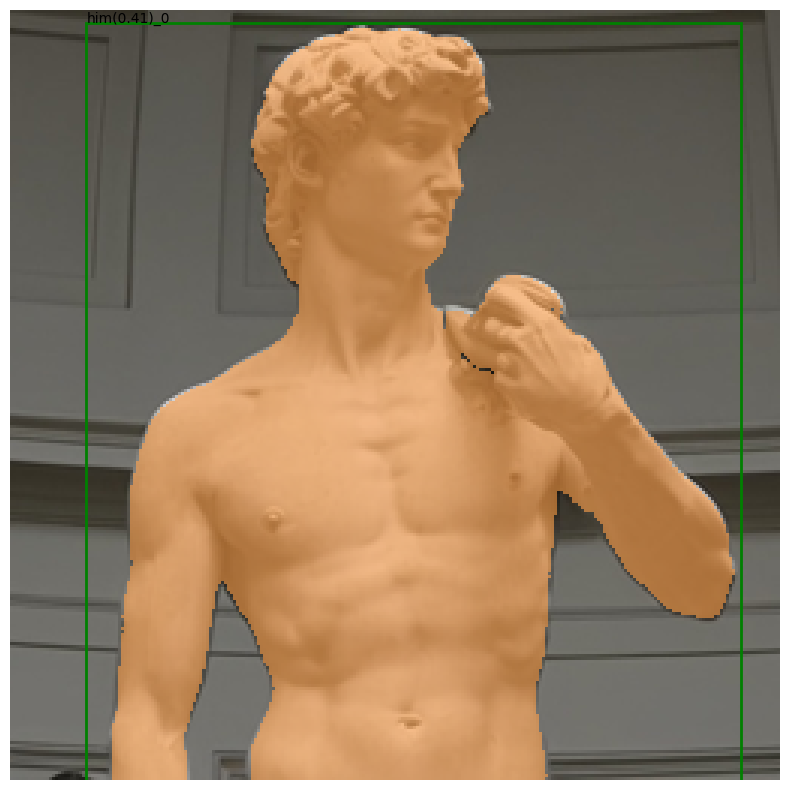

In [11]:
if __name__ == "__main__":

    # parser = argparse.ArgumentParser("Grounded-Segment-Anything Demo", add_help=True)
    # parser.add_argument("--sam_version", type=str, default="vit_h", required=False, help="SAM ViT version: vit_b / vit_l / vit_h")
    # parser.add_argument("--sam_checkpoint", type=str, required=False, help="path to sam checkpoint file")
    # parser.add_argument("--sam_hq_checkpoint", type=str, default=None, help="path to sam-hq checkpoint file")
    # parser.add_argument("--use_sam_hq", action="store_true", help="using sam-hq for prediction")
    # parser.add_argument("--text_prompt", type=str, required=True, help="text prompt")

    # parser.add_argument("--box_threshold", type=float, default=0.3, help="box threshold")
    # parser.add_argument("--text_threshold", type=float, default=0.25, help="text threshold")
    # parser.add_argument("--device", type=str, default="cpu", help="running on cpu only!, default=False")
    # parser.add_argument("--name", type=str, default="", help="name of the input image folder")
    # parser.add_argument("--size", type=int, default=1024, help="image size")

    # args = parser.parse_args()
    base_folder = "checkpoints"
    name = "input"
    input_folder = os.path.join(".", name)

    config = "GroundingDINO_SwinT_OGC.py"
    grounded_checkpoint = "groundingdino_swint_ogc.pth"
    sam_checkpoint="sam_vit_h_4b8939.pth"
    box_threshold = 0.3
    text_threshold = 0.25
    size = 256

    config_file = config
    grounded_checkpoint = os.path.join(base_folder,grounded_checkpoint)
    sam_version = "vit_h"
    sam_checkpoint = os.path.join(base_folder,sam_checkpoint)
    # if sam_hq_checkpoint is not None:
        # sam_hq_checkpoint = os.path.join(base_folder,sam_hq_checkpoint)
    # image_path = input_image
    # output_dir = output_dir
    use_sam_hq = False

    text_prompt = "him" # Text prompt
    device = "mps"

    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)

    # unify names
    if len(os.listdir(input_folder)) == 1:
        for filename in os.listdir(input_folder):
            imgtype = "." + filename.split(".")[-1]
            shutil.move(os.path.join(input_folder, filename), os.path.join(input_folder, "img"+imgtype))


    ### resizing and save
    if os.path.exists(os.path.join(input_folder, "img.jpg")):
        image_path = os.path.join(input_folder, "img.jpg")
    else:
        image_path = os.path.join(input_folder, "img.png")
    image = load_image_to_resize(image_path, size = size)
    image =Image.fromarray(image)
    resized_image_path = os.path.join(input_folder, "img_{}.png".format(size))
    image.save(resized_image_path)

    image_path = resized_image_path
    # load image
    image_pil, image = load_image(image_path)
    # load model
    model = load_model(config_file, grounded_checkpoint, device=device)

    # # visualize raw image
    # image_pil.save(os.path.join(output_dir, "raw_image.jpg"))

    # run grounding dino model
    boxes_filt, pred_phrases = get_grounding_output(
        model, image, text_prompt, box_threshold, text_threshold, device=device
    )

    # initialize SAM
    # if use_sam_hq:
        # predictor = SamPredictor(sam_hq_model_registry[sam_version](checkpoint=sam_hq_checkpoint).to(device))
    # else:

    predictor = SamPredictor(sam_model_registry[sam_version](checkpoint=sam_checkpoint).to(device))
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predictor.set_image(image)

    size = image_pil.size
    H, W = size[1], size[0]
    for i in range(boxes_filt.size(0)):
        boxes_filt[i] = boxes_filt[i] * torch.Tensor([W, H, W, H])
        boxes_filt[i][:2] -= boxes_filt[i][2:] / 2
        boxes_filt[i][2:] += boxes_filt[i][:2]

    boxes_filt = boxes_filt.cpu()
    transformed_boxes = predictor.transform.apply_boxes_torch(boxes_filt, image.shape[:2]).to(device)

    masks, _, _ = predictor.predict_torch(
        point_coords = None,
        point_labels = None,
        boxes = transformed_boxes.to(device),
        multimask_output = False,
    )

    tot_detect = len(masks)
    # draw output image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for idx, (mask,label) in enumerate(zip(masks,pred_phrases)):
        show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
        np.save( os.path.join(output_dir, "maskSAM{}_{}.npy".format(idx, label)) ,mask[0].cpu().numpy())

    for idx, (box, label) in enumerate(zip(boxes_filt, pred_phrases)):
        label = label + "_{}".format(idx)
        show_box(box.numpy(), plt.gca(), label)

    rec_mask = np.zeros_like(mask[0].cpu().numpy()).astype(np.bool_)
    for idx, box in enumerate(boxes_filt):
        up = box[0].numpy().astype(np.int32)
        down = box[2].numpy().astype(np.int32)
        left = box[1].numpy().astype(np.int32)
        right = box[3].numpy().astype(np.int32)
        rec_mask[left:right, up:down] = True

    plt.axis('off')
    plt.savefig(
        os.path.join(output_dir, "seg_init_SAM.png"),
        bbox_inches="tight", dpi=300, pad_inches=0.0
    )

    mask_detected = np.logical_or.reduce([mask[0].cpu().numpy() for mask in masks ])
    mask_undetected = np.logical_not(mask_detected)
    np.save( os.path.join(output_dir, "SAM_detected.npy") ,mask_detected)
    np.save( os.path.join(output_dir, "maskSAM{}_rest.npy".format(len(masks)))     ,mask_undetected)
    plt.imsave( os.path.join(output_dir,"mask_SAM-detected.png"), np.repeat(np.expand_dims( mask_detected.astype(float), axis=2), 3, axis = 2))


<Figure size 1000x1000 with 0 Axes>

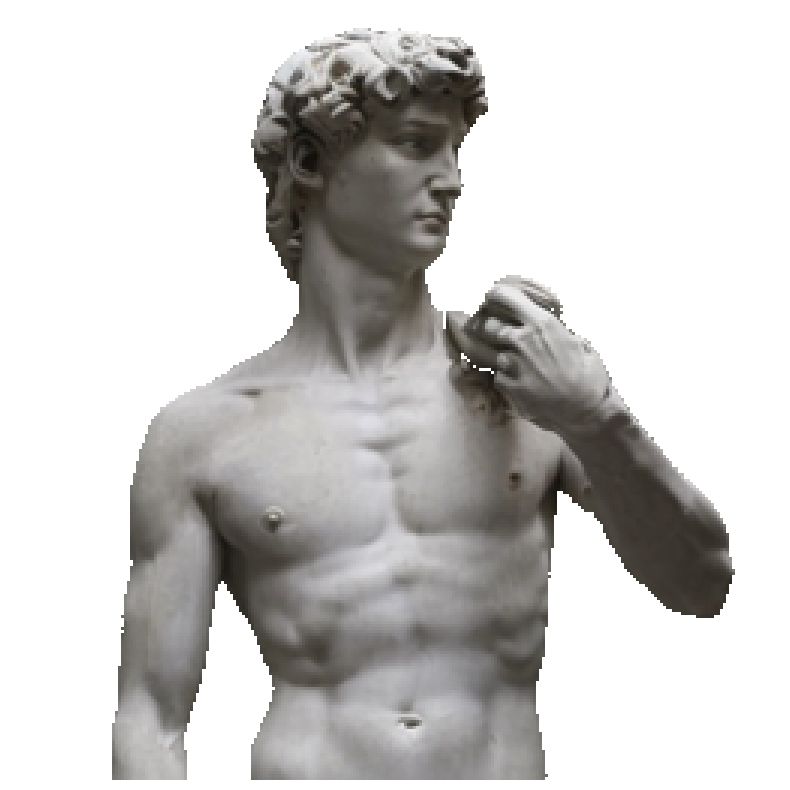

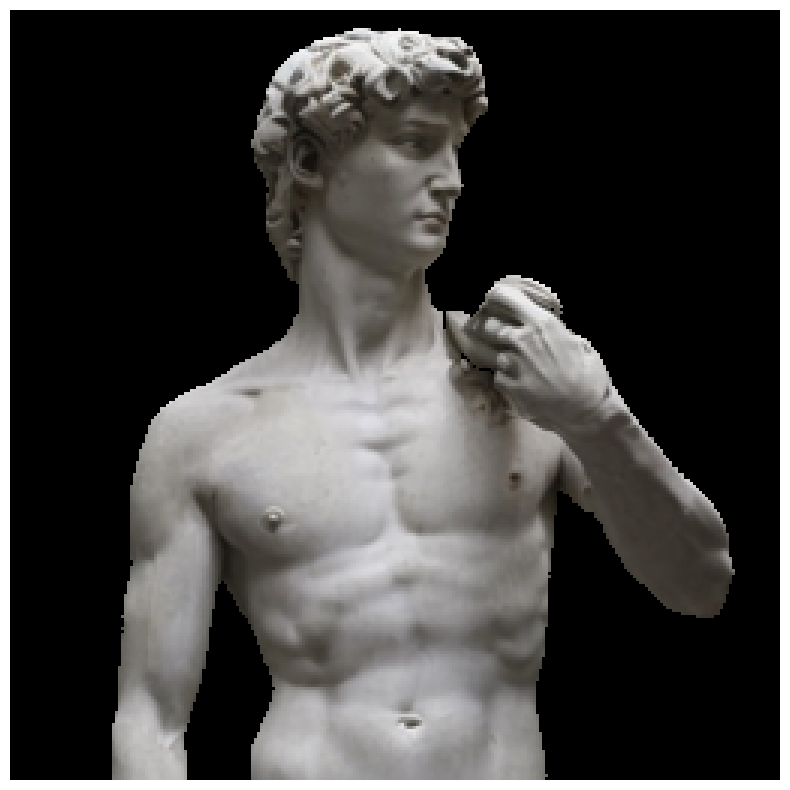

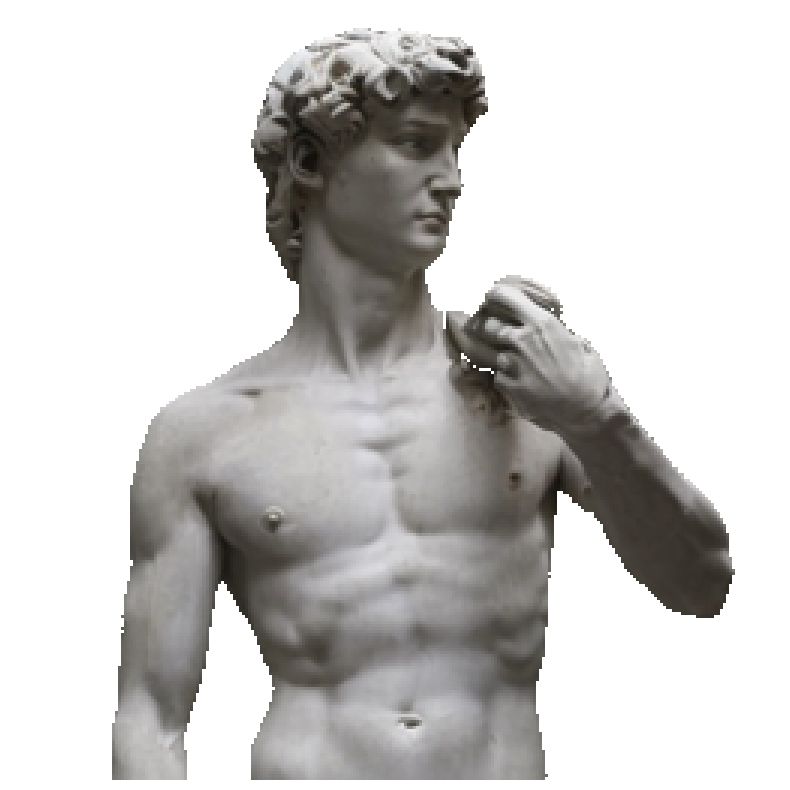

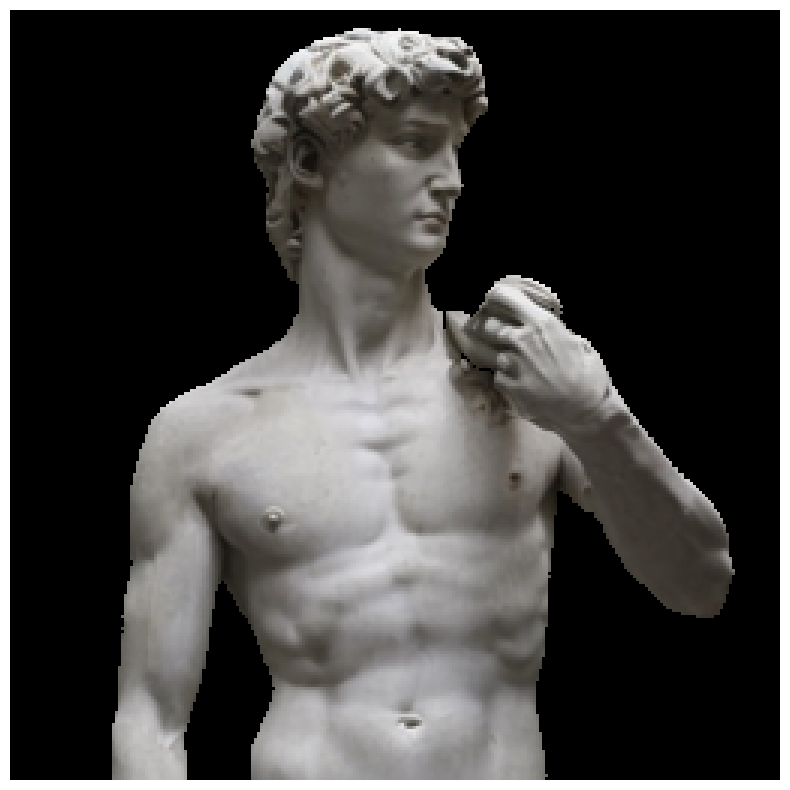

In [12]:
plt.figure(figsize=(10, 10))
white_bg = np.ones_like(image) * 255
black_bg = np.zeros_like(image)

white_mask_img = white_bg.copy()
for mask in masks:
    mask_np = mask[0].cpu().numpy()
    white_mask_img[mask_np] = image[mask_np]

black_mask_img = black_bg.copy()
for mask in masks:
    mask_np = mask[0].cpu().numpy()
    black_mask_img[mask_np] = image[mask_np]

plt.figure(figsize=(10, 10))
plt.imshow(white_mask_img)
plt.axis('off')
plt.savefig(
    os.path.join(output_dir, "mask_only_white_bg.png"),
    bbox_inches="tight", dpi=300, pad_inches=0.0
)

plt.figure(figsize=(10, 10))
plt.imshow(black_mask_img)
plt.axis('off')
plt.savefig(
    os.path.join(output_dir, "mask_only_black_bg.png"),
    bbox_inches="tight", dpi=300, pad_inches=0.0
)

for idx, mask in enumerate(masks):
    mask_np = mask[0].cpu().numpy()

    single_white_mask = white_bg.copy()
    single_white_mask[mask_np] = image[mask_np]

    plt.figure(figsize=(10, 10))
    plt.imshow(single_white_mask)
    plt.axis('off')
    plt.savefig(
        os.path.join(output_dir, f"mask_{idx}_white_bg.png"),
        bbox_inches="tight", dpi=300, pad_inches=0.0
    )

    single_black_mask = black_bg.copy()
    single_black_mask[mask_np] = image[mask_np]

    plt.figure(figsize=(10, 10))
    plt.imshow(single_black_mask)
    plt.axis('off')
    plt.savefig(
        os.path.join(output_dir, f"mask_{idx}_black_bg.png"),
        bbox_inches="tight", dpi=300, pad_inches=0.0
    )